### Training

In [1]:
import importlib

import utils.sound_utils as su
import utils.train_utils as tu
import utils.filter_utils as filter
import utils.plot_utils as pu

from sklearn import tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


import wget

import os
import sys
import importlib
import pickle
import numpy as np
import pandas as pd

importlib.reload(su)
importlib.reload(tu)
importlib.reload(pu)
importlib.reload(filter)


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils.filter_utils' from 'c:\\Users\\gonza\\OneDrive\\Documentos\\Gonzalo\\Especializacion\\inteligencia_embebida\\esp32_loopback\\python\\utils\\filter_utils.py'>

In [32]:

#wget.download('https://www.dropbox.com/s/d12x5vknrk9yek1/data.zip')
#wget.download('https://www.dropbox.com/s/qoyduoa5prupyzr/test_files.csv')
#wget.download('https://www.dropbox.com/s/z1cwznln0gfpw32/train_labels.csv')

In [6]:
labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}

In [7]:
train_labels = pd.read_csv("data/train_labels.csv")
test_labels = pd.read_csv("data/test_files.csv")

In [8]:
train_labels.head()

,filename,pasture,height,label
0,4,alfalfa,tall,2
1,9,alfalfa,tall,2
2,10,alfalfa,tall,1
3,11,alfalfa,tall,2
4,13,alfalfa,tall,2


In [36]:
test_labels.head()

,filename
0,1
1,2
2,3
3,5
4,6


In [37]:
dataset = tu.upload_dataset("data/audios")

In [38]:
len(dataset)

3083

In [ ]:
sample_rate = 22050
f_cutoff = 5
f_norm = f_cutoff / sample_rate
window_size = (0.196202 + f_norm ** 2) ** 0.5 / f_norm

filter_ma = filter.MovingAverage(window_size=int(window_size))
filtered_data = []


for _, audio in dataset:
    filtered_aux = []
    for value in audio:
        absolute = abs(value) if abs(value) >= 0 else np.iinfo(value.dtype).max
        filtered_aux.append(filter_ma.calculate_ma(absolute))
    filtered_data.append(filtered_aux)
    
    

In [12]:
with open('data/filtered_data.pkl', 'wb') as f:
    pickle.dump(filtered_data, f)

NameError: name 'filtered_data' is not defined

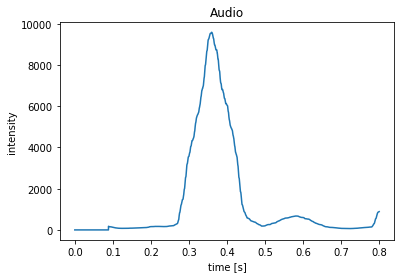

In [ ]:
from utils.sound_utils import plot_audio

plot_audio(filtered_data[0], sample_rate)

In [ ]:
noise_gate_data = []
noise_gate = su.NoiseGate(open_threshold=1500, close_threshold=1000, hold=0)
for data in filtered_data:
    filtered_data_list, init, end = noise_gate.split(data, sample_rate)
    if len(filtered_data_list) == 1:
        noise_gate_data.append(filtered_data_list[0])
    elif len(filtered_data_list) > 0:
        noise_gate_data.append(filtered_data_list[0])
    else:
        noise_gate_data.append([])

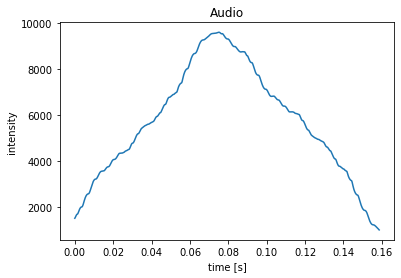

In [ ]:
plot_audio(noise_gate_data[0], sample_rate)

In [ ]:
extracted_data = []
for data in noise_gate_data:
    extractor = su.FeatureExtractor(data, sample_rate)
    extracted_data.append(extractor.extract_features())

In [ ]:
with open('data/extracted_data.pkl', 'wb') as f:
    pickle.dump(extracted_data, f)

In [3]:
file = open('data/extracted_data.pkl', 'rb')
extracted_data = pickle.load(file)

In [17]:
extracted_data[0]

[0.15863945578231292,
 9584.596006144386,
 63,
 0.47566218969130075,
 2383.2023133242296]

In [4]:
import pandas.testing as tm
import seaborn

colnames = ["Duracion", "Cruces", "Maximo", "Simetria", "Desvio"]

df_train = pd.DataFrame(extracted_data, columns=colnames)
df_train.insert(len(df_train.columns), "Class", train["label"])

seaborn.pairplot(df_train,
                 vars=colnames,
                 hue="Class",
                 plot_kws={'alpha':0.2},
                 palette="bright")

NameError: name 'train' is not defined

### Training

In [2]:
X_data = np.array(extracted_data)
X_data.size
len(extracted_data)

NameError: name 'extracted_data' is not defined

In [23]:
from itertools import count


X_data = extracted_data
y_data = train_labels.label.to_list()

X_train = []
y_train = []

test_indexes = test_labels.filename.to_list()
counter = 0
for i, value in enumerate(extracted_data):
    if value == []:
        continue
    if i not in test_indexes:
        X_train.append(value)
        y_train.append(str(y_data[counter]))
        counter += 1


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.33,
                                                    random_state=42)

In [26]:
models = {}
params = {'criterion': ['gini','entropy'], 'splitter': ['best','random'], 'max_depth': [2, 3, 4]}
model = tu.get_best_model(DecisionTreeClassifier, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), params, models, "model_dt") 


{'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}
Grid search time: 0.22649480000836775 s
              precision    recall  f1-score   support

           0    0.35000   0.28000   0.31111        50
           1    0.66532   0.88710   0.76037       186
           2    0.68627   0.33981   0.45455       103

    accuracy                        0.63127       339
   macro avg    0.56720   0.50230   0.50868       339
weighted avg    0.62518   0.63127   0.60119       339

Training time: 0.0022217000368982553 s


[Text(0.5, 0.8333333333333334, 'X[4] <= 690.016\ngini = 0.58\nsamples = 687\nvalue = [107, 386, 194]\nclass = y[1]'),
 Text(0.25, 0.5, 'X[0] <= 0.022\ngini = 0.489\nsamples = 509\nvalue = [66, 344, 99]\nclass = y[1]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.358\nsamples = 229\nvalue = [30, 180, 19]\nclass = y[1]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.559\nsamples = 280\nvalue = [36, 164, 80]\nclass = y[1]'),
 Text(0.75, 0.5, 'X[2] <= 113.5\ngini = 0.606\nsamples = 178\nvalue = [41, 42, 95]\nclass = y[2]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.638\nsamples = 77\nvalue = [31, 15, 31]\nclass = y[0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.517\nsamples = 101\nvalue = [10, 27, 64]\nclass = y[2]')]

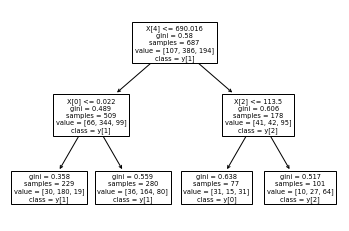

In [29]:
from turtle import width
import matplotlib.pyplot as plt

labels = {
    0: "bite",
    1: "chew",
    2: "chew_byte"
}


tree.plot_tree(model.model, features_names=[], class_names=["bite", "chew", "chew_bite"])


In [30]:
plt.savefig('tree.png', format='png', bbox_inches = "tight", dpi=200)

<Figure size 432x288 with 0 Axes>